# 📘 02_classical_models.ipynb

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import joblib

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# 🔹 Load Data

In [14]:
X_kmer = np.load("data/processed/X_kmer.npy")
X_onehot = np.load("data/processed/X_onehot.npy")
y = np.load("data/processed/y_labels.npy")

print("✅ Loaded:")
print("X_kmer:", X_kmer.shape)
print("X_onehot:", X_onehot.shape)
print("y_labels:", y.shape)

✅ Loaded:
X_kmer: (131, 64)
X_onehot: (131, 402, 5)
y_labels: (131,)


# 🔹 Train/Test Split

In [15]:
Xk_train, Xk_test, yk_train, yk_test = train_test_split(
    X_kmer, y, test_size=0.3, random_state=42, stratify=y
)
Xo_train, Xo_test, yo_train, yo_test = train_test_split(
    X_onehot, y, test_size=0.3, random_state=42, stratify=y
)

# 🔹 1. Support Vector Machine (SVM)

In [16]:
svm = SVC(kernel='rbf', probability=True)
svm.fit(Xk_train, yk_train)
y_pred_svm = svm.predict(Xk_test)
y_proba_svm = svm.predict_proba(Xk_test)[:, 1]

# 🔹 2. Random Forest

In [17]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(Xk_train, yk_train)
y_pred_rf = rf.predict(Xk_test)
y_proba_rf = rf.predict_proba(Xk_test)[:, 1]

# 🔹 3. CNN (for One-hot Sequences)

In [18]:
cnn = Sequential([
    Conv1D(64, 5, activation='relu', input_shape=Xo_train.shape[1:]),
    MaxPooling1D(2),
    Dropout(0.2),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

cnn_history = cnn.fit(
    Xo_train, yo_train,
    epochs=10,
    batch_size=16,
    validation_split=0.2,
    verbose=1
)

y_pred_cnn = (cnn.predict(Xo_test) > 0.5).astype("int32").flatten()
y_proba_cnn = cnn.predict(Xo_test).flatten()

Epoch 1/10
5/5 [==============================] - 1s 40ms/step - loss: 0.6974 - accuracy: 0.5972 - val_loss: 0.6635 - val_accuracy: 0.4737
Epoch 2/10
5/5 [==============================] - 0s 16ms/step - loss: 0.5362 - accuracy: 0.7083 - val_loss: 0.6832 - val_accuracy: 0.4737
Epoch 3/10
5/5 [==============================] - 0s 15ms/step - loss: 0.4618 - accuracy: 0.7083 - val_loss: 0.6408 - val_accuracy: 0.7895
Epoch 4/10
5/5 [==============================] - 0s 13ms/step - loss: 0.4213 - accuracy: 0.8889 - val_loss: 0.6494 - val_accuracy: 0.8421
Epoch 5/10
5/5 [==============================] - 0s 14ms/step - loss: 0.3924 - accuracy: 0.8333 - val_loss: 0.6308 - val_accuracy: 0.8421
Epoch 6/10
5/5 [==============================] - 0s 14ms/step - loss: 0.3433 - accuracy: 0.9028 - val_loss: 0.5404 - val_accuracy: 0.8421
Epoch 7/10
5/5 [==============================] - 0s 14ms/step - loss: 0.2661 - accuracy: 0.9444 - val_loss: 0.6327 - val_accuracy: 0.8421
Epoch 8/10
5/5 [===========

# 🧪 Evaluation Utilities

In [19]:
def evaluate_model(y_true, y_pred, y_proba, name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)

    print(f"📊 {name} Results:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"AUC:       {auc:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{name} ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

def build_metrics_dict(y_true, y_pred, y_proba, model_name):
    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-Score": f1_score(y_true, y_pred),
        "AUC": roc_auc_score(y_true, y_proba)
    }

# 📊 Evaluate All Models

📊 SVM Results:
Accuracy:  0.9750
Precision: 0.9630
Recall:    1.0000
F1-score:  0.9811
AUC:       0.9725


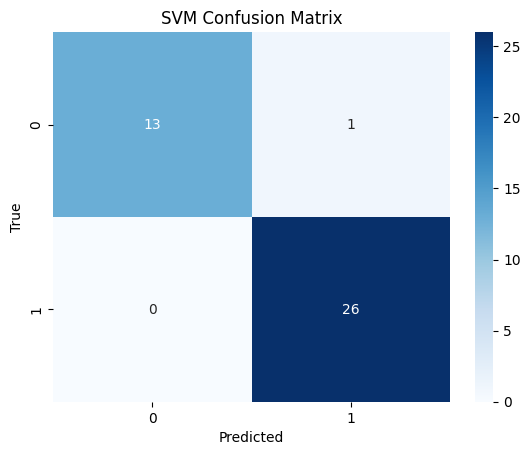

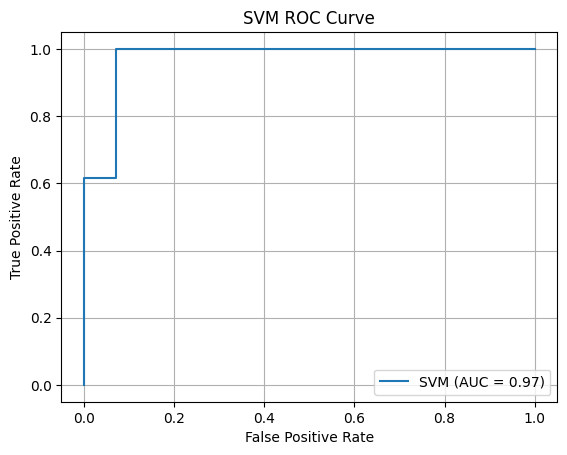

📊 Random Forest Results:
Accuracy:  0.9250
Precision: 0.9600
Recall:    0.9231
F1-score:  0.9412
AUC:       0.9560


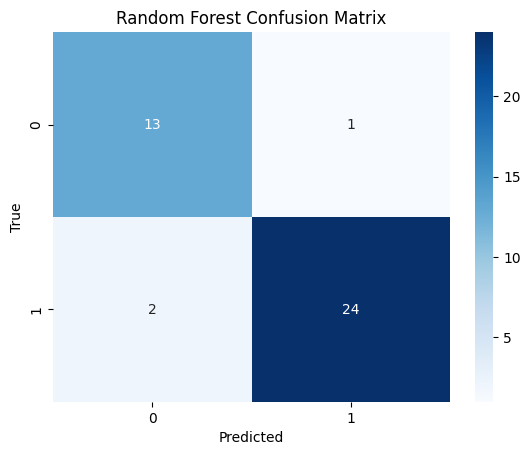

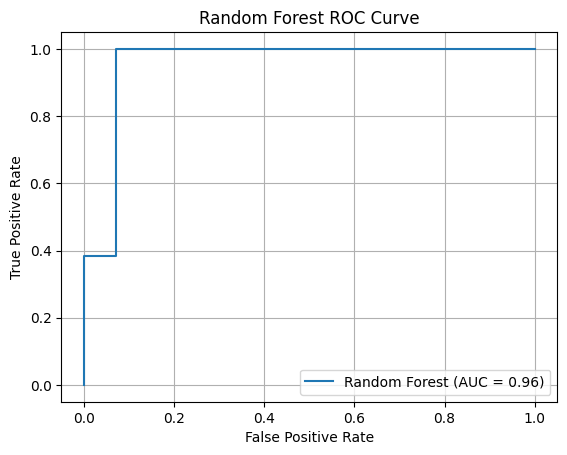

📊 CNN Results:
Accuracy:  0.9000
Precision: 0.8667
Recall:    1.0000
F1-score:  0.9286
AUC:       0.9588


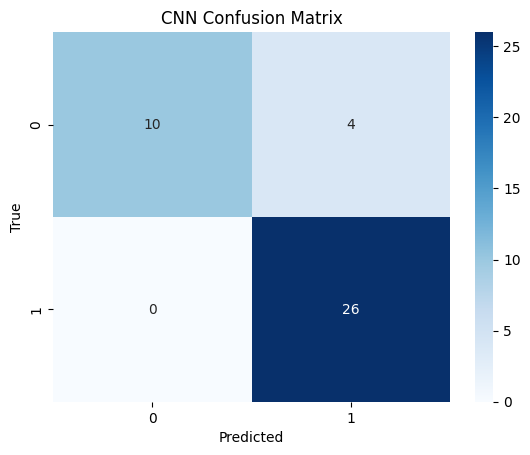

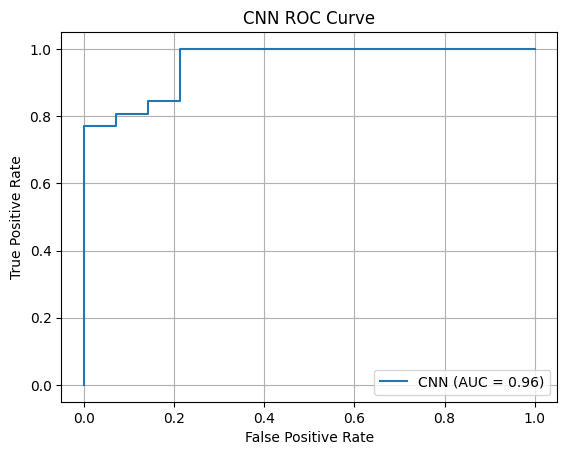

In [20]:
evaluate_model(yk_test, y_pred_svm, y_proba_svm, "SVM")
evaluate_model(yk_test, y_pred_rf, y_proba_rf, "Random Forest")
evaluate_model(yo_test, y_pred_cnn, y_proba_cnn, "CNN")

# 💾 Save All Trained Models

In [21]:
os.makedirs("models/classical", exist_ok=True)
joblib.dump(svm, "models/classical/svm_model.pkl")
joblib.dump(rf, "models/classical/rf_model.pkl")
cnn.save("models/classical/cnn_model.h5")
print("✅ Models saved to models/classical/")

✅ Models saved to models/classical/


# 📤 Export Results to CSVs

In [22]:
os.makedirs("results/metrics", exist_ok=True)

# A. Export metrics
metrics = [
    build_metrics_dict(yk_test, y_pred_svm, y_proba_svm, "SVM"),
    build_metrics_dict(yk_test, y_pred_rf, y_proba_rf, "Random Forest"),
    build_metrics_dict(yo_test, y_pred_cnn, y_proba_cnn, "CNN"),
]
df_metrics = pd.DataFrame(metrics)
df_metrics.to_csv("results/metrics/classical_model_metrics.csv", index=False)
print("✅ Saved: classical_model_metrics.csv")

# B. Export confusion matrices
def save_confusion_matrix(y_true, y_pred, name):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, columns=["Pred_0", "Pred_1"], index=["True_0", "True_1"])
    df_cm.to_csv(f"results/metrics/confusion_matrix_{name.lower().replace(' ', '_')}.csv")

save_confusion_matrix(yk_test, y_pred_svm, "SVM")
save_confusion_matrix(yk_test, y_pred_rf, "Random Forest")
save_confusion_matrix(yo_test, y_pred_cnn, "CNN")

# C. Export predictions
def save_predictions(y_true, y_pred, y_proba, name):
    df = pd.DataFrame({
        "True_Label": y_true,
        "Predicted_Label": y_pred,
        "Predicted_Probability": y_proba
    })
    df.to_csv(f"results/metrics/predictions_{name.lower().replace(' ', '_')}.csv", index=False)

save_predictions(yk_test, y_pred_svm, y_proba_svm, "SVM")
save_predictions(yk_test, y_pred_rf, y_proba_rf, "Random Forest")
save_predictions(yo_test, y_pred_cnn, y_proba_cnn, "CNN")

print("🎉 Model training, evaluation, and export complete.")

✅ Saved: classical_model_metrics.csv
🎉 Model training, evaluation, and export complete.
